# Clasificación de correos de spam con modelo de Decision Tree


In [ ]:
%pip install pandas numpy matplotlib seaborn ucimlrepo

In [2]:
import pandas as pd
import numpy as np
from ucimlrepo import fetch_ucirepo 
import matplotlib.pyplot as plt
import seaborn as sns


Traemos el dataset directamente de ucirepo debido a un error en las variables con la version de descarga

In [4]:
spambase = fetch_ucirepo(id=94) 
X = spambase.data.features
y = spambase.data.targets

X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4601 entries, 0 to 4600
Data columns (total 57 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   word_freq_make              4601 non-null   float64
 1   word_freq_address           4601 non-null   float64
 2   word_freq_all               4601 non-null   float64
 3   word_freq_3d                4601 non-null   float64
 4   word_freq_our               4601 non-null   float64
 5   word_freq_over              4601 non-null   float64
 6   word_freq_remove            4601 non-null   float64
 7   word_freq_internet          4601 non-null   float64
 8   word_freq_order             4601 non-null   float64
 9   word_freq_mail              4601 non-null   float64
 10  word_freq_receive           4601 non-null   float64
 11  word_freq_will              4601 non-null   float64
 12  word_freq_people            4601 non-null   float64
 13  word_freq_report            4601 

In [5]:
X.describe()

,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,word_freq_mail,...,word_freq_conference,char_freq_;,char_freq_(,char_freq_[,char_freq_!,char_freq_$,char_freq_#,capital_run_length_average,capital_run_length_longest,capital_run_length_total
count,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,...,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000
mean,0.104553,0.213015,0.280656,0.065425,0.312223,0.095901,0.114208,0.105295,0.090067,0.239413,...,0.031869,0.038575,0.139030,0.016976,0.269071,0.075811,0.044238,5.191515,52.172789,283.289285
std,0.305358,1.290575,0.504143,1.395151,0.672513,0.273824,0.391441,0.401071,0.278616,0.644755,...,0.285735,0.243471,0.270355,0.109394,0.815672,0.245882,0.429342,31.729449,194.891310,606.347851
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.588000,6.000000,35.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.065000,0.000000,0.000000,0.000000,0.000000,2.276000,15.000000,95.000000
75%,0.000000,0.000000,0.420000,0.000000,0.380000,0.000000,0.000000,0.000000,0.000000,0.160000,...,0.000000,0.000000,0.188000,0.000000,0.315000,0.052000,0.000000,3.706000,43.000000,266.000000
max,4.540000,14.280000,5.100000,42.810000,10.000000,5.880000,7.270000,11.110000,5.260000,18.180000,...,10.000000,4.385000,9.752000,4.081000,32.478000,6.003000,19.829000,1102.500000,9989.000000,15841.000000


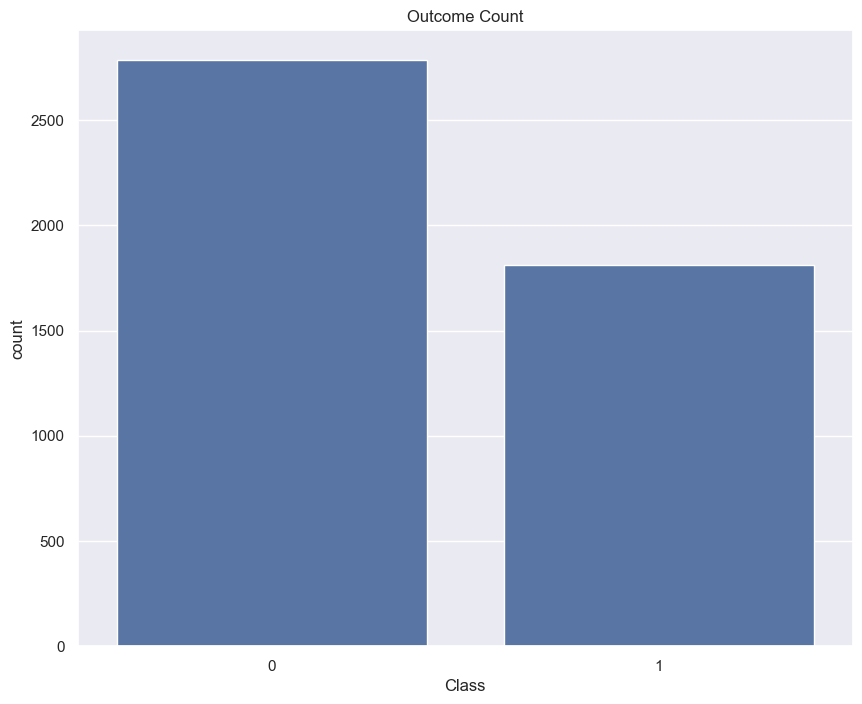

In [86]:
#Histograma del atributo clase
ax=plt.subplots(1,1,figsize=(10,8))
sns.countplot(x='Class',data=y)
plt.title("Outcome Count")
plt.show()

[[('word_freq_415', 'word_freq_857'), 0.9961],
 [('word_freq_direct', 'word_freq_857'), 0.848],
 [('word_freq_857', 'word_freq_415'), 0.9961],
 [('word_freq_direct', 'word_freq_415'), 0.8454],
 [('word_freq_857', 'word_freq_direct'), 0.848],
 [('word_freq_415', 'word_freq_direct'), 0.8454]]

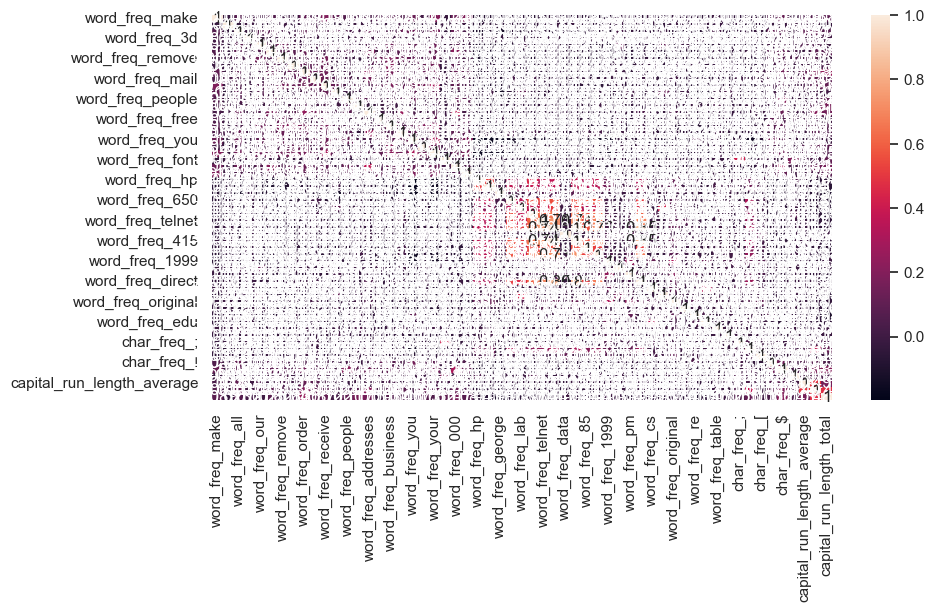

In [84]:
#matriz de correlación
cor_matrix = X.corr().round(4)
plt.figure(figsize=(10,5))
sns.heatmap(data=cor_matrix, annot=True)
high_cor = []
for col in cor_matrix:
    for row in cor_matrix:
        value = cor_matrix[row][col]
        if row != col and value >= 0.8:
            high_cor.append([(row,col),value])

high_cor

variances
word_freq_857: 0.3285231745896935
word_freq_415: 0.32940952722597405
word_freq_direct: 0.3498779548771617


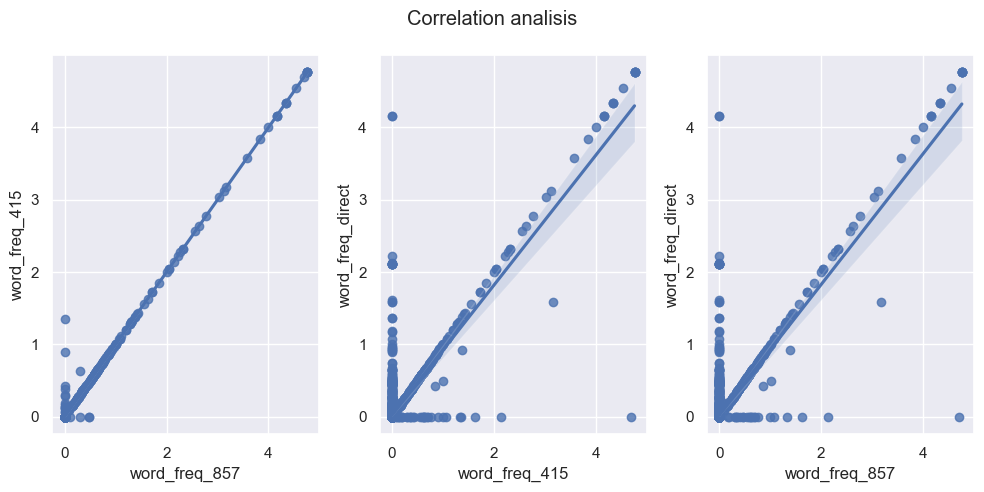

In [76]:
#observando relaciones entre los datos
fig, axes = plt.subplots(1,3, figsize=(10,5))
fig.suptitle('Correlation analisis')

sns.regplot(ax=axes[0], y='word_freq_415', x='word_freq_857', data=X);
sns.regplot(ax=axes[1], x='word_freq_415', y='word_freq_direct', data=X);
sns.regplot(ax=axes[2], x='word_freq_857', y='word_freq_direct', data=X);

plt.tight_layout()

print("variances")
print(f'word_freq_857: {np.std(X["word_freq_857"])}')
print(f'word_freq_415: {np.std(X["word_freq_415"])}')
print(f'word_freq_direct: {np.std(X["word_freq_direct"])}')

plt.show()